## Udacity CharityML project

This notebook contains solution of Udacity CharityML project using Yandex CatBoost classifier,
a tool for gradient boosting on decision trees, which is well suited for categorical features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, FeaturesData, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score


The data contains 45221 records with census and income data (more or less than 50K)

In [2]:
data=pd.read_csv('census.csv')
print(data)

       age          workclass education_level  education-num  \
0       39          State-gov       Bachelors           13.0   
1       50   Self-emp-not-inc       Bachelors           13.0   
2       38            Private         HS-grad            9.0   
3       53            Private            11th            7.0   
4       28            Private       Bachelors           13.0   
5       37            Private         Masters           14.0   
6       49            Private             9th            5.0   
7       52   Self-emp-not-inc         HS-grad            9.0   
8       31            Private         Masters           14.0   
9       42            Private       Bachelors           13.0   
10      37            Private    Some-college           10.0   
11      30          State-gov       Bachelors           13.0   
12      23            Private       Bachelors           13.0   
13      32            Private      Assoc-acdm           12.0   
14      34            Private         7t

We will construct a model that predicts the income based on the census data.
Start with data preprocessing. Replace the income column with 0 (less than 50K) and 1 (more than 50K)
Split train and test sets. Scale numerical features. Note that we do not need to do one-hot encoding for categorical features to use CatBoost.

In [3]:
data['income']=data['income'].apply(lambda x: (x=='>50K'))
features=data.drop(columns=['income'])
outcomes=data['income']
features_train,features_test, outcomes_train, outcomes_test=train_test_split(features,outcomes,test_size=0.2,random_state=23)
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
scaler.fit(features[numerical])
features[numerical]=scaler.transform(data[numerical])


Initialize CatBoost classifier. Parameters:
- depth: maximal depth of decision trees
- iterations: number of decision trees
- cat_features: column indices that correspond to categorical features
- od_type: type of overfitting detector, here we set it to 'Iter' to evaluate loss on test set after every iteration
- od_wait: number of iterations to continue after the iteration with optimal loss value on the test set

In [4]:
cbclf=CatBoostClassifier(depth=9,iterations=3000,cat_features=[1,2,4,5,6,7,8,12],od_type='Iter',od_wait=300)

Create the Pool out of test data and train the classifier

In [5]:
testPool=Pool(data=features_test.values,label=outcomes_test.values,cat_features=[1,2,4,5,6,7,8,12])
cbclf.fit(features_train,outcomes_train,eval_set=testPool)

Learning rate set to 0.071069
0:	learn: 0.6154976	test: 0.6152954	best: 0.6152954 (0)	total: 426ms	remaining: 21m 16s
1:	learn: 0.5553370	test: 0.5548798	best: 0.5548798 (1)	total: 759ms	remaining: 18m 58s
2:	learn: 0.5109360	test: 0.5103866	best: 0.5103866 (2)	total: 1.09s	remaining: 18m 7s
3:	learn: 0.4739304	test: 0.4733112	best: 0.4733112 (3)	total: 1.37s	remaining: 17m 8s
4:	learn: 0.4476700	test: 0.4472426	best: 0.4472426 (4)	total: 1.55s	remaining: 15m 31s
5:	learn: 0.4263009	test: 0.4257158	best: 0.4257158 (5)	total: 1.92s	remaining: 15m 58s
6:	learn: 0.4070765	test: 0.4069048	best: 0.4069048 (6)	total: 2.2s	remaining: 15m 39s
7:	learn: 0.3909874	test: 0.3907738	best: 0.3907738 (7)	total: 2.52s	remaining: 15m 42s
8:	learn: 0.3784447	test: 0.3783958	best: 0.3783958 (8)	total: 2.85s	remaining: 15m 46s
9:	learn: 0.3679267	test: 0.3681576	best: 0.3681576 (9)	total: 3.23s	remaining: 16m 5s
10:	learn: 0.3584348	test: 0.3585945	best: 0.3585945 (10)	total: 3.6s	remaining: 16m 17s
11:	l

93:	learn: 0.2871779	test: 0.2905263	best: 0.2905263 (93)	total: 25.9s	remaining: 13m 19s
94:	learn: 0.2871569	test: 0.2905170	best: 0.2905170 (94)	total: 26s	remaining: 13m 14s
95:	learn: 0.2871222	test: 0.2904744	best: 0.2904744 (95)	total: 26.1s	remaining: 13m 10s
96:	learn: 0.2868900	test: 0.2904102	best: 0.2904102 (96)	total: 26.3s	remaining: 13m 8s
97:	learn: 0.2867238	test: 0.2902972	best: 0.2902972 (97)	total: 26.5s	remaining: 13m 5s
98:	learn: 0.2865497	test: 0.2902402	best: 0.2902402 (98)	total: 26.9s	remaining: 13m 8s
99:	learn: 0.2864987	test: 0.2902399	best: 0.2902399 (99)	total: 27s	remaining: 13m 4s
100:	learn: 0.2859194	test: 0.2895860	best: 0.2895860 (100)	total: 27.5s	remaining: 13m 8s
101:	learn: 0.2859126	test: 0.2895941	best: 0.2895860 (100)	total: 27.6s	remaining: 13m 3s
102:	learn: 0.2856021	test: 0.2892729	best: 0.2892729 (102)	total: 27.9s	remaining: 13m 3s
103:	learn: 0.2855628	test: 0.2892442	best: 0.2892442 (103)	total: 28s	remaining: 12m 59s
104:	learn: 0.2

184:	learn: 0.2769531	test: 0.2821061	best: 0.2821061 (184)	total: 48s	remaining: 12m 10s
185:	learn: 0.2769001	test: 0.2820701	best: 0.2820701 (185)	total: 48.3s	remaining: 12m 11s
186:	learn: 0.2767925	test: 0.2820560	best: 0.2820560 (186)	total: 48.7s	remaining: 12m 11s
187:	learn: 0.2767902	test: 0.2820557	best: 0.2820557 (187)	total: 48.8s	remaining: 12m 9s
188:	learn: 0.2766741	test: 0.2819495	best: 0.2819495 (188)	total: 49.2s	remaining: 12m 12s
189:	learn: 0.2766162	test: 0.2818960	best: 0.2818960 (189)	total: 49.6s	remaining: 12m 13s
190:	learn: 0.2765104	test: 0.2818172	best: 0.2818172 (190)	total: 49.9s	remaining: 12m 14s
191:	learn: 0.2763528	test: 0.2816196	best: 0.2816196 (191)	total: 50.5s	remaining: 12m 18s
192:	learn: 0.2762484	test: 0.2816083	best: 0.2816083 (192)	total: 51s	remaining: 12m 21s
193:	learn: 0.2762154	test: 0.2815909	best: 0.2815909 (193)	total: 51.4s	remaining: 12m 22s
194:	learn: 0.2761011	test: 0.2815265	best: 0.2815265 (194)	total: 51.7s	remaining: 1

274:	learn: 0.2715465	test: 0.2792797	best: 0.2792797 (274)	total: 1m 21s	remaining: 13m 22s
275:	learn: 0.2715425	test: 0.2792786	best: 0.2792786 (275)	total: 1m 21s	remaining: 13m 22s
276:	learn: 0.2715425	test: 0.2792824	best: 0.2792786 (275)	total: 1m 21s	remaining: 13m 20s
277:	learn: 0.2715276	test: 0.2792990	best: 0.2792786 (275)	total: 1m 21s	remaining: 13m 21s
278:	learn: 0.2715200	test: 0.2792872	best: 0.2792786 (275)	total: 1m 22s	remaining: 13m 21s
279:	learn: 0.2714994	test: 0.2792514	best: 0.2792514 (279)	total: 1m 22s	remaining: 13m 22s
280:	learn: 0.2714979	test: 0.2792551	best: 0.2792514 (279)	total: 1m 22s	remaining: 13m 22s
281:	learn: 0.2714800	test: 0.2792326	best: 0.2792326 (281)	total: 1m 23s	remaining: 13m 22s
282:	learn: 0.2713559	test: 0.2791716	best: 0.2791716 (282)	total: 1m 23s	remaining: 13m 22s
283:	learn: 0.2712777	test: 0.2791364	best: 0.2791364 (283)	total: 1m 23s	remaining: 13m 22s
284:	learn: 0.2712757	test: 0.2791363	best: 0.2791363 (284)	total: 1m 

363:	learn: 0.2677480	test: 0.2779455	best: 0.2779329 (361)	total: 1m 57s	remaining: 14m 12s
364:	learn: 0.2676355	test: 0.2778931	best: 0.2778931 (364)	total: 1m 58s	remaining: 14m 17s
365:	learn: 0.2674871	test: 0.2778641	best: 0.2778641 (365)	total: 1m 59s	remaining: 14m 23s
366:	learn: 0.2673945	test: 0.2778209	best: 0.2778209 (366)	total: 2m	remaining: 14m 27s
367:	learn: 0.2673914	test: 0.2778208	best: 0.2778208 (367)	total: 2m 1s	remaining: 14m 29s
368:	learn: 0.2673893	test: 0.2778209	best: 0.2778208 (367)	total: 2m 2s	remaining: 14m 31s
369:	learn: 0.2673871	test: 0.2778213	best: 0.2778208 (367)	total: 2m 3s	remaining: 14m 35s
370:	learn: 0.2673314	test: 0.2778312	best: 0.2778208 (367)	total: 2m 4s	remaining: 14m 40s
371:	learn: 0.2673241	test: 0.2778325	best: 0.2778208 (367)	total: 2m 5s	remaining: 14m 44s
372:	learn: 0.2673081	test: 0.2778447	best: 0.2778208 (367)	total: 2m 6s	remaining: 14m 48s
373:	learn: 0.2672947	test: 0.2778503	best: 0.2778208 (367)	total: 2m 7s	remaini

452:	learn: 0.2644806	test: 0.2774061	best: 0.2773545 (448)	total: 2m 44s	remaining: 15m 25s
453:	learn: 0.2644492	test: 0.2774296	best: 0.2773545 (448)	total: 2m 45s	remaining: 15m 26s
454:	learn: 0.2644472	test: 0.2774295	best: 0.2773545 (448)	total: 2m 45s	remaining: 15m 25s
455:	learn: 0.2644102	test: 0.2774119	best: 0.2773545 (448)	total: 2m 45s	remaining: 15m 25s
456:	learn: 0.2643962	test: 0.2774045	best: 0.2773545 (448)	total: 2m 46s	remaining: 15m 24s
457:	learn: 0.2643859	test: 0.2774014	best: 0.2773545 (448)	total: 2m 46s	remaining: 15m 24s
458:	learn: 0.2643777	test: 0.2773948	best: 0.2773545 (448)	total: 2m 46s	remaining: 15m 24s
459:	learn: 0.2643720	test: 0.2773948	best: 0.2773545 (448)	total: 2m 47s	remaining: 15m 24s
460:	learn: 0.2643718	test: 0.2773948	best: 0.2773545 (448)	total: 2m 47s	remaining: 15m 23s
461:	learn: 0.2643469	test: 0.2774101	best: 0.2773545 (448)	total: 2m 48s	remaining: 15m 22s
462:	learn: 0.2643217	test: 0.2774042	best: 0.2773545 (448)	total: 2m 

541:	learn: 0.2620524	test: 0.2772037	best: 0.2771817 (517)	total: 3m 25s	remaining: 15m 32s
542:	learn: 0.2620256	test: 0.2772029	best: 0.2771817 (517)	total: 3m 26s	remaining: 15m 32s
543:	learn: 0.2620229	test: 0.2772017	best: 0.2771817 (517)	total: 3m 26s	remaining: 15m 31s
544:	learn: 0.2619204	test: 0.2772265	best: 0.2771817 (517)	total: 3m 26s	remaining: 15m 31s
545:	learn: 0.2618129	test: 0.2772011	best: 0.2771817 (517)	total: 3m 27s	remaining: 15m 30s
546:	learn: 0.2617962	test: 0.2772120	best: 0.2771817 (517)	total: 3m 27s	remaining: 15m 29s
547:	learn: 0.2617947	test: 0.2772146	best: 0.2771817 (517)	total: 3m 27s	remaining: 15m 29s
548:	learn: 0.2617828	test: 0.2772147	best: 0.2771817 (517)	total: 3m 28s	remaining: 15m 28s
549:	learn: 0.2617495	test: 0.2771950	best: 0.2771817 (517)	total: 3m 28s	remaining: 15m 28s
550:	learn: 0.2617123	test: 0.2771954	best: 0.2771817 (517)	total: 3m 28s	remaining: 15m 27s
551:	learn: 0.2617103	test: 0.2771954	best: 0.2771817 (517)	total: 3m 

630:	learn: 0.2607334	test: 0.2770150	best: 0.2769979 (626)	total: 3m 58s	remaining: 14m 57s
631:	learn: 0.2607217	test: 0.2770104	best: 0.2769979 (626)	total: 3m 59s	remaining: 14m 57s
632:	learn: 0.2607172	test: 0.2770088	best: 0.2769979 (626)	total: 3m 59s	remaining: 14m 56s
633:	learn: 0.2607154	test: 0.2770117	best: 0.2769979 (626)	total: 4m	remaining: 14m 56s
634:	learn: 0.2606872	test: 0.2770173	best: 0.2769979 (626)	total: 4m	remaining: 14m 56s
635:	learn: 0.2606856	test: 0.2770146	best: 0.2769979 (626)	total: 4m 1s	remaining: 14m 56s
636:	learn: 0.2606515	test: 0.2770243	best: 0.2769979 (626)	total: 4m 1s	remaining: 14m 56s
637:	learn: 0.2605705	test: 0.2769756	best: 0.2769756 (637)	total: 4m 2s	remaining: 14m 56s
638:	learn: 0.2605685	test: 0.2769706	best: 0.2769706 (638)	total: 4m 2s	remaining: 14m 56s
639:	learn: 0.2605458	test: 0.2769731	best: 0.2769706 (638)	total: 4m 3s	remaining: 14m 57s
640:	learn: 0.2605448	test: 0.2769716	best: 0.2769706 (638)	total: 4m 3s	remaining:

719:	learn: 0.2589786	test: 0.2769512	best: 0.2769082 (692)	total: 4m 40s	remaining: 14m 48s
720:	learn: 0.2589432	test: 0.2769571	best: 0.2769082 (692)	total: 4m 41s	remaining: 14m 48s
721:	learn: 0.2589402	test: 0.2769616	best: 0.2769082 (692)	total: 4m 41s	remaining: 14m 48s
722:	learn: 0.2589318	test: 0.2769643	best: 0.2769082 (692)	total: 4m 42s	remaining: 14m 48s
723:	learn: 0.2588756	test: 0.2770164	best: 0.2769082 (692)	total: 4m 42s	remaining: 14m 48s
724:	learn: 0.2588637	test: 0.2770218	best: 0.2769082 (692)	total: 4m 43s	remaining: 14m 49s
725:	learn: 0.2588582	test: 0.2770234	best: 0.2769082 (692)	total: 4m 43s	remaining: 14m 49s
726:	learn: 0.2588568	test: 0.2770253	best: 0.2769082 (692)	total: 4m 44s	remaining: 14m 49s
727:	learn: 0.2588564	test: 0.2770253	best: 0.2769082 (692)	total: 4m 44s	remaining: 14m 49s
728:	learn: 0.2588438	test: 0.2770176	best: 0.2769082 (692)	total: 4m 45s	remaining: 14m 49s
729:	learn: 0.2588067	test: 0.2769998	best: 0.2769082 (692)	total: 4m 

808:	learn: 0.2579030	test: 0.2769164	best: 0.2769082 (692)	total: 5m 17s	remaining: 14m 18s
809:	learn: 0.2579017	test: 0.2769270	best: 0.2769082 (692)	total: 5m 17s	remaining: 14m 18s
810:	learn: 0.2578968	test: 0.2769162	best: 0.2769082 (692)	total: 5m 17s	remaining: 14m 17s
811:	learn: 0.2578895	test: 0.2769204	best: 0.2769082 (692)	total: 5m 18s	remaining: 14m 17s
812:	learn: 0.2578758	test: 0.2769256	best: 0.2769082 (692)	total: 5m 18s	remaining: 14m 16s
813:	learn: 0.2578663	test: 0.2769274	best: 0.2769082 (692)	total: 5m 19s	remaining: 14m 16s
814:	learn: 0.2578189	test: 0.2769357	best: 0.2769082 (692)	total: 5m 19s	remaining: 14m 16s
815:	learn: 0.2578172	test: 0.2769340	best: 0.2769082 (692)	total: 5m 19s	remaining: 14m 15s
816:	learn: 0.2578100	test: 0.2769385	best: 0.2769082 (692)	total: 5m 20s	remaining: 14m 15s
817:	learn: 0.2578015	test: 0.2769446	best: 0.2769082 (692)	total: 5m 20s	remaining: 14m 15s
818:	learn: 0.2577942	test: 0.2769483	best: 0.2769082 (692)	total: 5m 

897:	learn: 0.2562555	test: 0.2769829	best: 0.2769082 (692)	total: 5m 59s	remaining: 14m 1s
898:	learn: 0.2562543	test: 0.2769833	best: 0.2769082 (692)	total: 5m 59s	remaining: 14m 1s
899:	learn: 0.2562341	test: 0.2769855	best: 0.2769082 (692)	total: 6m	remaining: 14m 1s
900:	learn: 0.2562316	test: 0.2769892	best: 0.2769082 (692)	total: 6m 1s	remaining: 14m 1s
901:	learn: 0.2561963	test: 0.2769837	best: 0.2769082 (692)	total: 6m 1s	remaining: 14m 1s
902:	learn: 0.2561894	test: 0.2769869	best: 0.2769082 (692)	total: 6m 2s	remaining: 14m 1s
903:	learn: 0.2561646	test: 0.2769642	best: 0.2769082 (692)	total: 6m 3s	remaining: 14m 1s
904:	learn: 0.2561645	test: 0.2769642	best: 0.2769082 (692)	total: 6m 3s	remaining: 14m 1s
905:	learn: 0.2561613	test: 0.2769606	best: 0.2769082 (692)	total: 6m 4s	remaining: 14m 1s
906:	learn: 0.2561613	test: 0.2769619	best: 0.2769082 (692)	total: 6m 4s	remaining: 14m
907:	learn: 0.2561591	test: 0.2769611	best: 0.2769082 (692)	total: 6m 4s	remaining: 14m
908:	l

986:	learn: 0.2547379	test: 0.2772401	best: 0.2769082 (692)	total: 6m 44s	remaining: 13m 44s
987:	learn: 0.2547379	test: 0.2772401	best: 0.2769082 (692)	total: 6m 44s	remaining: 13m 43s
988:	learn: 0.2547348	test: 0.2772350	best: 0.2769082 (692)	total: 6m 45s	remaining: 13m 43s
989:	learn: 0.2547256	test: 0.2772246	best: 0.2769082 (692)	total: 6m 45s	remaining: 13m 43s
990:	learn: 0.2547255	test: 0.2772246	best: 0.2769082 (692)	total: 6m 46s	remaining: 13m 43s
991:	learn: 0.2547148	test: 0.2772295	best: 0.2769082 (692)	total: 6m 46s	remaining: 13m 43s
992:	learn: 0.2547136	test: 0.2772296	best: 0.2769082 (692)	total: 6m 47s	remaining: 13m 43s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.2769081621
bestIteration = 692

Shrink model to first 693 iterations.


Model evaluation:
- ROC auc score
- F1 score
- accuracy

In [6]:
y_train_pred=cbclf.predict_proba(features_train)[:, 1]
y_test_pred=cbclf.predict_proba(features_test)[:, 1]
print('Model ROC auc score on train set:',roc_auc_score(outcomes_train,y_train_pred))
print('Model ROC auc score on test:',roc_auc_score(outcomes_test,y_test_pred))
y_train_pred=y_train_pred>0.5
y_test_pred=y_test_pred>0.5
print('Model F1 score on train set:',f1_score(outcomes_train,y_train_pred))
print('Model F1 score on test set:',f1_score(outcomes_test,y_test_pred))
print('Model accuracy on train set:',accuracy_score(outcomes_train,y_train_pred))
print('Model accuracy on test set:',accuracy_score(outcomes_test,y_test_pred))



Model ROC auc score on train set: 0.936229341476
Model ROC auc score on test: 0.931095740332
Model F1 score on train set: 0.73251177963
Model F1 score on test set: 0.718916303822
Model accuracy on train set: 0.877601791193
Model accuracy on test set: 0.871531232725


Five most important features:

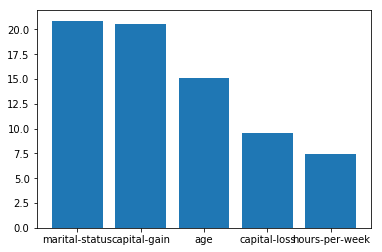

In [7]:
importances = cbclf.feature_importances_
indices = np.argsort(importances)[::-1]
columns = features_train.columns.values[indices[:5]]
values = importances[indices][:5]

plt.bar(np.arange(5),values,tick_label=columns)
plt.show()
